# OpenStreetMap: Historical Analysis

In this notebook, we analyze the evolution of OpenStreetMap availability through time from 2011 to 2018. More specifically, we are interested in the mapping trends related to the road network, the buildings footprints, and land use polygons.

## Imports & Parameters

In [2]:
import os
import sys
from functools import partial
from itertools import product
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm_notebook as tqdm
from shapely.geometry import shape, mapping
import json
import subprocess

In [3]:
# Add local module to the path
src = os.path.abspath('../src')
if src not in sys.path:
    sys.path.append(src)

In [4]:
from metadata import City, CITIES
from generate_aoi import reproject_geom, as_geojson

In [5]:
%matplotlib inline

In [6]:
# Plotting style
plt.style.use(['seaborn-paper', 'seaborn-whitegrid'])
plt.rc('font', family='serif', serif='cmr10', size=12)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('figure', titlesize=12)
plt.rc('text', usetex=True)
plt.rc('savefig', dpi=300)

In [7]:
KEYS = ['highway', 'building', 'leisure', 'natural', 'landuse']
YEARS = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

In [8]:
def prettify(city_name):
    """Better city name."""
    city_name = city_name.replace('_', '-')
    city_name = city_name.title()
    return city_name

## Data Acquisition

OpenStreetMap data are downloaded from the [Geofabrik](http://download.geofabrik.de) website. Two kinds of data files are available: (1) full dumps that contains all the historical informations (e.g. when each feature has been added, corrected or removed), identified by the `osh.pbf` extension, and (2) default dumps that contains the latest snapshot of the OpenStreetMap data, identified by the `osm.pbf`. In this case, we are interested in the first one. NB: the full historical dump for Africa has a size of `3.3GB` as of April 2018.

In [8]:
africa_history_f = os.path.abspath(os.path.join('../data/input/osm/africa.osh.pbf'))

In [9]:
if not os.path.isfile(africa_history_f):
    
    africa_history_url = 'http://download.geofabrik.de/africa.osh.pbf'
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    r = requests.get(africa_history_url, stream=True)
    size = int(r.headers['Content-Length'])
    progress = tqdm(total=size, unit='B', unit_scale=True)
    
    with open(africa_history_f, 'wb') as f:
    
        for chunk in r.iter_content(chunk_size=1024):

            if chunk:
                
                f.write(chunk)
                progress.update(1024)
    
    progress.close()

## Data Pre-Processing

Data pre-processing is mainly performed with the [`osmium`](http://osmcode.org/osmium-tool/) command-line tool. The documentation is available [here](http://osmcode.org/osmium-tool/manual.html#the-osmium-command).

### Geographical extracts

We create geographical extracts of the full history dump (based on the area of interest of each case study) using the `osmium extract --with-history` command. The area of interest is provided through a bounding box string such as `16.87,-22.74,17.26,-22.37`.

In [10]:
progress = tqdm(total=len(CITIES))

for city_name in CITIES:

    city = City(city_name)

    # In our case, the AOI is stored in an UTM CRS
    # Osmium requires a GeoJSON file in lat/lon coordinates
    aoi = shape(city.aoi)
    aoi = reproject_geom(aoi, city.epsg, 4326)
    bbox = '{},{},{},{}'.format(*aoi.bounds)

    history_dump = os.path.join(city.intermediary_dir, 'osm', 'history', 'dump.osh.pbf')
    os.makedirs(os.path.dirname(history_dump), exist_ok=True)

    if not os.path.isfile(history_dump):

        subprocess.run([
            'osmium', 'extract', '-b', bbox,
            '--with-history', '--overwrite',
            '-o', history_dump, africa_history_f
        ])

    progress.update(1)

progress.close()

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

### Filtering by year and by tags

We are looking for informations related to various OSM objects: roads, buildings footprints, and potentially non-built polygons (i.e. leisure, landuse, and natural). The objective is to produce one data file for each object of interest at multiple years and for each case study. The processing makes use of three different `osmium` commands. Firstly, yearly temporal extracts are produced for each case study using the `osmium time-filter` command. Then, individual data files are extracted for each object of interest using the `osmium tags-filter` command. Finally, the data files are converted to the GEOJSON format using the `osmium export` command.

In [31]:
time = '{year}-01-01T00:00:00Z'

progress = tqdm(total=len(CITIES) * len(YEARS) * len(KEYS))

for city_name in CITIES:
    
    city = City(city_name)
    
    full_dump = os.path.join(city.intermediary_dir, 'osm', 'history', 'dump.osh.pbf')
    
    for year in YEARS:
        
        output_dir = os.path.join(city.intermediary_dir, 'osm', 'history', str(year))
        os.makedirs(output_dir, exist_ok=True)
        
        yearly_dump = os.path.join(output_dir, 'dump.osm.pbf')
                
        subprocess.run([
            'osmium', 'time-filter', '-O', '-o', yearly_dump,
            full_dump, time.format(year=year)
        ])
        
        for key in KEYS:
            
            filtered_dump = os.path.join(output_dir, '{}.osm.pbf'.format(key))
            
            filt_expression = 'w/{}'.format(key)
            
            subprocess.run([
                'osmium', 'tags-filter', '-O', '-o', filtered_dump,
                yearly_dump, filt_expression
            ])
            
            geojson = os.path.join(output_dir, 'dump_{}.geojson'.format(key))
            
            subprocess.run([
                'osmium', 'export', '-O', '-o', geojson, filtered_dump
            ])
                    
            # Keep only objects of a given geometry type
            # and fix geometries that are not contained by the AOI.
            # Also reproject to an UTM CRS
            if key == 'highway':
                geom_type = 'LineString'
            else:
                geom_type = 'MultiPolygon'
                
            try:
                features = gpd.read_file(geojson)
                features = features[features.geom_type == geom_type]
                features = features.to_crs(city.crs)
                features = features[features.intersects(shape(city.aoi))]
                features.to_file(os.path.join(output_dir, key + '.geojson'), driver='GeoJSON')
            except:
                pass
                
            progress.update(1)
            
        # Remove useless files
        for file in os.listdir(output_dir):
            if 'osm.pbf' in file or 'dump' in file:
                os.remove(os.path.join(output_dir, file))

progress.close()

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

As a result, for each case study and each year between 2011 and 2018, we have the following data files:

- `highway.geojson`
- `building.geojson`
- `landuse.geojson`
- `leisure.geojson`
- `natural.geojson`

## Local analysis

In [9]:
def count_and_measure(geojson_file, area_of_interest):
    """Count & measure objects available in a GeoJSON file."""
    features = gpd.read_file(geojson_file)
    geometries = features.intersection(area_of_interest)
    features = features.assign(geometry=geometries)
    
    n = len(features)
    
    if features.type[0] == 'LineString':
        s = features.length.sum()
    else:
        s = features.area.sum()
    
    return n, round(s)

In [10]:
index = pd.MultiIndex.from_product((CITIES, KEYS))
count = pd.DataFrame(index=index, columns=YEARS)
sizes = pd.DataFrame(index=index, columns=YEARS)

In [11]:
progress = tqdm(total=len(CITIES) * len(YEARS) * len(KEYS))

for city_name in CITIES:
    
    city = City(city_name)
    aoi = shape(city.aoi)
    
    for year in YEARS:
        
        data_dir = os.path.join(city.intermediary_dir, 'osm', 'history', str(year))
        
        for key in KEYS:
            
            geojson_path = os.path.join(data_dir, key + '.geojson')
            if os.path.isfile(geojson_path):
                n, s = count_and_measure(geojson_path, aoi)
                count.at[((city_name, key), year)] = n
                sizes.at[((city_name, key), year)] = s
            progress.update(1)

progress.close()

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

In [12]:
# Replace NaN by 0
count = count.replace(np.nan, 0)
sizes = sizes.replace(np.nan, 0)

# Convert sizes to km and ha
def convert(row):
    """Convert lengths to km and surfaces to ha."""
    (city_name, key), data = row
    if key == 'highway':
        data *= 1e-3
    else:
        data *= 1e-4
    func = partial(round, ndigits=1)
    return data.map(func)

for i, row in enumerate(sizes.iterrows()):
    sizes.iloc[i] = convert(row)

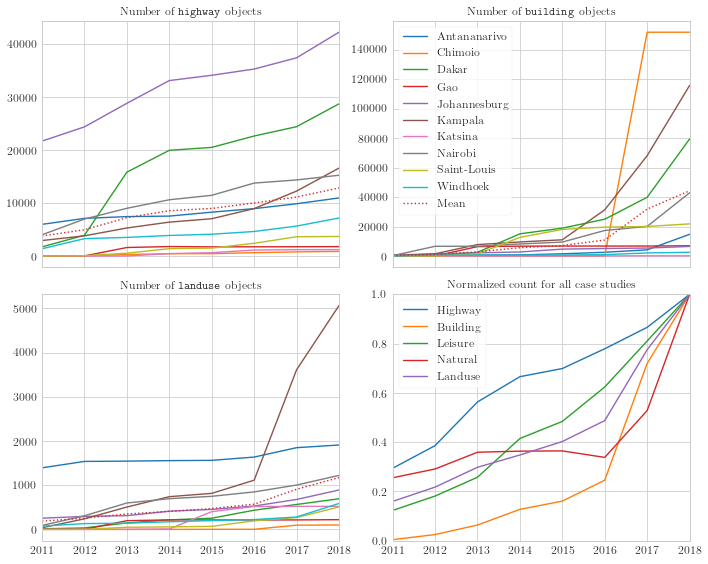

In [13]:
f, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)

for key, ax in zip(('highway', 'building', 'landuse'), axes.flat):
    
    evolution = count.xs(key, level=1)
    evolution.index = evolution.index.map(prettify)
    evolution.T.plot(ax=ax)
    ax.plot(evolution.mean(), label='Mean', linestyle=':', color='C3')
    ax.legend([])
    ax.set_xlim(2011, 2018)
    ax.set_title('Number of $\\texttt{{{key}}}$ objects'.format(key=key))
    
for key in KEYS:
    
    evolution = count.xs(key, level=1).sum()
    evolution = evolution / evolution.max()
    axes[1][1].plot(evolution, label=key.title())
    axes[1][1].set_xlim(2011, 2018)
    axes[1][1].set_ylim(0, 1)
    axes[1][1].legend(ncol=1, frameon=True)
    axes[1][1].set_title('Normalized count for all case studies')
    
axes.flat[1].legend(ncol=1, frameon=True)
f.tight_layout()

f.savefig('../paper/figures/osm_history_local.pdf')
f.savefig('../paper/figures/osm_history_local.png');

## Global analysis

Geographical extracts are available through the [Geofabrik](https://www.geofabrik.de/data/download.html) website at various years (mainly from January 2014 to January 2018). Here, we collect the file size in bytes for various continents or countries from 2014 to 2018 by requesting HTTP headers to the website.

In [14]:
CONTINENTS = ['africa', 'antarctica', 'asia',  'australia-oceania', 'central-america', 'europe', 'north-america', 'south-america']
COUNTRIES = ['germany', 'france', 'belgium', 'spain', 'italy', 'mozambique', 'uganda', 'nigeria', 'madagascar', 'namibia']
YEARS = ['2014', '2015', '2016', '2017', '2018']

In [15]:
def get_size(continent, year, country=None):
    """Get size in bytes of the OSM file of a given continent for a given year.
    Request HTTP headers from the geofabrik.de website to get the file size in bytes.
    """
    year = str(year)[-2:]
    if country:
        url = 'http://download.geofabrik.de/{}/{}-{}0101.osm.pbf'.format(continent, country, year)
    else:
        url = 'http://download.geofabrik.de/{}-{}0101.osm.pbf'.format(continent, year)
    r = requests.head(url)
    if r.status_code == 200:
        size = r.headers['Content-Length']
        return int(size)
    else:
        return None

In [16]:
size_per_continent = pd.DataFrame(index=CONTINENTS, columns=YEARS)
size_per_country = pd.Series(index=COUNTRIES)

In [17]:
for continent, year in product(CONTINENTS, YEARS):
    size = get_size(continent, year)
    size_per_continent.at[(continent, year)] = size

for country in COUNTRIES:
    size = get_size('africa', 2018, country)
    if not size:
        size = get_size('europe', 2018, country)
    size_per_country.loc[country] = size

Convert Bytes to Gigabytes:

In [18]:
size_per_continent *= 1e-9
size_per_country *= 1e-9

In [19]:
func = partial(round, ndigits=2)
size_per_continent = size_per_continent.applymap(func)
size_per_country = size_per_country.map(func)

In [20]:
size_per_continent

,2014,2015,2016,2017,2018
africa,0.44,0.72,1.02,1.52,2.11
antarctica,0.03,0.03,0.03,0.03,0.03
asia,2.48,3.01,3.80,4.50,5.56
australia-oceania,0.28,0.35,0.42,0.48,0.53
central-america,0.17,0.21,0.17,0.24,0.32
europe,10.87,13.36,15.32,17.05,18.64
north-america,5.79,6.38,6.95,7.48,8.03
south-america,0.44,0.60,0.73,0.96,1.19


In [21]:
size_per_country

germany       2.85
france        3.42
belgium       0.29
spain         0.64
italy         1.28
mozambique    0.10
uganda        0.06
nigeria       0.10
madagascar    0.04
namibia       0.02
dtype: float64

In [22]:
for c in ('antarctica', 'central-america'):
    if c in size_per_continent.index:
        size_per_continent.drop(c, axis=0, inplace=True)

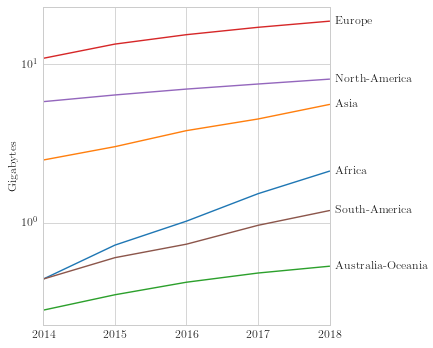

In [23]:
f, ax = plt.subplots(figsize=(5,5))

for continent in size_per_continent.index:
    
    evolution = size_per_continent.loc[continent]
    ax.plot(evolution, label=continent.title())
    ax.set_yscale('log')

ax.set_xlim(2014, 2018)
ax.set_ylabel('Gigabytes')

for line in ax.lines:
    y = line.get_ydata()[-1]
    label = line.get_label()
    annot = ax.annotate(label, xy=(1, y), xytext=(5, 0), xycoords=ax.get_yaxis_transform(), textcoords='offset points', va='center')

f.tight_layout();
f.savefig('../paper/figures/osm_per_continent.pdf', bbox_inches='tight')
f.savefig('../paper/figures/osm_per_continent.png', bbox_inches='tight');

Save dataframes to disk:

In [24]:
output_dir = os.path.abspath('../data/output')
os.makedirs(output_dir, exist_ok=True)

output_f = os.path.join(output_dir, 'osm_evolution_continent.csv')
size_per_continent.to_csv(output_f)

output_f = os.path.join(output_dir, 'osm_evolution_city.csv')
sizes.to_csv(output_f)